Good, let’s turn that into a concrete recipe.

Assume you have monthly market excess returns (r_1,\dots,r_T) (≈100 years).

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Make the package importable when running from repo root or notebooks/
repo_root = pathlib.Path.cwd()
if (repo_root / "src").exists():
    sys.path.append(str(repo_root / "src"))
else:  # if launched from notebooks/, walk up one level
    sys.path.append(str((repo_root / "../src").resolve()))

from finance_data.french import load_us_research_factors_wide
from finance_data import metrics
from finance_data.ar_garch import (
    fit_ar_garch_t,
    run_parameter_uncertainty_experiment,
)
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
# Fetch Mkt-RF and RF back to 1926 (monthly, decimals)
factors_wide, rf = load_us_research_factors_wide(start_date="1926-07-01")
factors_wide = factors_wide.rename(columns={"Mkt-RF": "Mkt_RF"}) if "Mkt-RF" in factors_wide.columns else factors_wide

mkt_excess = factors_wide["Mkt_RF"].dropna()
rf = rf.reindex(mkt_excess.index)
mkt_total = mkt_excess + rf

print("Coverage:")
print("Start", mkt_excess.index.min().date(), "End", mkt_excess.index.max().date(), "N obs", mkt_excess.shape[0])


Coverage:
Start 1926-07-31 End 2025-09-30 N obs 1191


---
## Curved EF fit for returns
Implement a small curved exponential family on standardized market excess returns to damp skewness and kurtosis before the AR–GARCH baseline.


In [3]:
# Curved exponential family fit on standardized market excess returns.
returns_clean = mkt_excess.dropna().astype(float)
mu0 = float(returns_clean.mean())
s0 = float(returns_clean.std(ddof=0))
s0 = s0 if s0 > 0.0 and np.isfinite(s0) else 1.0
returns_standardized = ((returns_clean - mu0) / s0).to_numpy()

def t_vec(x, qL, qR):
    return np.array([
        x,
        x ** 2,
        x ** 3,
        x ** 4,
        1.0 * (x < qL),
        1.0 * (x > qR),
    ], dtype=float)

x = returns_standardized
n = len(x)
qL = float(np.quantile(x, 0.05))
qR = float(np.quantile(x, 0.95))
Tmat = np.stack([t_vec(xi, qL, qR) for xi in x], axis=0)

newton_tol = 1e-6
newton_max_iter = 20
beta_max_iter = 50
ridge = 1e-6

def loglik_grad_hess(theta, Tmat):
    u = Tmat @ theta
    u_max = float(u.max())
    w = np.exp(u - u_max)
    Z = float(w.sum())
    p = w / Z

    Et = Tmat.T @ p
    tbar = Tmat.mean(axis=0)

    ll = float(np.dot(theta, tbar) - np.log(Z) - u_max)
    grad = tbar - Et
    centered = Tmat - Et
    Fisher = (centered.T * p) @ centered
    return ll * n, grad * n, Fisher * n

theta = np.zeros(Tmat.shape[1], dtype=float)
Fisher = np.eye(Tmat.shape[1])
for _ in range(newton_max_iter):
    ll, grad, Fisher = loglik_grad_hess(theta, Tmat)
    try:
        step = np.linalg.solve(Fisher + ridge * np.eye(len(theta)), grad)
    except np.linalg.LinAlgError:
        step = np.linalg.pinv(Fisher + ridge * np.eye(len(theta))) @ grad
    theta += step
    if np.linalg.norm(step) < newton_tol:
        break
theta_hat = theta.copy()
kappa_hat = Fisher / n

eigvals, eigvecs = np.linalg.eigh(kappa_hat)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

rng = np.random.default_rng(1234)
perm = rng.permutation(n)
split = max(1, min(n - 1, int(0.8 * n)))
train_idx, val_idx = perm[:split], perm[split:]
T_train = Tmat[train_idx]
T_val = Tmat[val_idx]

def build_phi(Vm):
    return lambda beta: theta_hat + Vm @ beta

def fit_beta_for_m(m):
    Vm = eigvecs[:, :m]
    phi = build_phi(Vm)
    beta = np.zeros(m, dtype=float)

    Fisher_theta = np.eye(m)
    for _ in range(beta_max_iter):
        theta_m = phi(beta)
        ll_m, grad_theta, Fisher_theta = loglik_grad_hess(theta_m, T_train)
        grad_beta = Vm.T @ grad_theta
        Fisher_beta = Vm.T @ Fisher_theta @ Vm
        try:
            step = np.linalg.solve(Fisher_beta + ridge * np.eye(m), grad_beta)
        except np.linalg.LinAlgError:
            step = np.linalg.pinv(Fisher_beta + ridge * np.eye(m)) @ grad_beta
        beta += step
        if np.linalg.norm(step) < newton_tol:
            break

    if T_val.shape[0] == 0:
        return beta, -np.inf, Vm

    theta_m = phi(beta)
    u_val = T_val @ theta_m
    u_max_val = float(u_val.max())
    w_val = np.exp(u_val - u_max_val)
    Z_val = float(w_val.sum())
    ll_val = (theta_m @ T_val.mean(axis=0) - np.log(Z_val) - u_max_val) * T_val.shape[0]
    return beta, ll_val / max(1, T_val.shape[0]), Vm

scores = []
lambda1 = 0.01
lambda2 = 0.01
for m in range(1, Tmat.shape[1] + 1):
    beta_m, ll_val_mean, Vm = fit_beta_for_m(m)
    lambdas_m = eigvals[:m]
    cond_m = float(lambdas_m[0] / max(lambdas_m[-1], 1e-12))
    score_m = ll_val_mean - lambda1 * m - lambda2 * np.log(max(cond_m, 1e-12))
    scores.append(
        {
            "m": m,
            "score": score_m,
            "val_ll": ll_val_mean,
            "cond": cond_m,
            "beta": beta_m,
            "Vm": Vm,
        }
    )

best = max(scores, key=lambda z: z["score"])
m_star = best["m"]
beta_star = best["beta"]
Vm_star = best["Vm"]
theta_star = theta_hat + Vm_star @ beta_star

u_star = Tmat @ theta_star
u_star_max = float(u_star.max())
p_star = np.exp(u_star - u_star_max)
p_star = p_star / float(p_star.sum())

mu_star = float(np.sum(p_star * x))
centered_x = x - mu_star
var_star = float(np.sum(p_star * centered_x ** 2))
skew_star = float(np.sum(p_star * centered_x ** 3) / np.power(var_star, 1.5))
kurt_star = float(np.sum(p_star * centered_x ** 4) / (var_star ** 2))
baseline_skew = float(pd.Series(x).skew())
baseline_kurt = float(stats.kurtosis(x, fisher=False, bias=False))

curved_ef_fit = {
    "theta_hat": theta_hat,
    "theta_star": theta_star,
    "beta_star": beta_star,
    "Vm_star": Vm_star,
    "eigvals": eigvals,
    "eigvecs": eigvecs,
    "scores": scores,
    "weights": p_star,
    "qL": qL,
    "qR": qR,
    "mu0": mu0,
    "s0": s0,
    "weighted_skew": skew_star,
    "weighted_kurt": kurt_star,
    "baseline_skew": baseline_skew,
    "baseline_kurt": baseline_kurt,
}

scores_table = pd.DataFrame(scores).sort_values("score", ascending=False)
display(scores_table[["m", "score", "val_ll", "cond"]])

print(f"Selected m = {m_star} (score={best['score']:.4f}, val LL={best['val_ll']:.4f}, cond={best['cond']:.2f})")
print(f"Baseline skew/kurt: {baseline_skew:.3f}, {baseline_kurt:.3f}")
print(f"Weighted skew/kurt under curved EF: {skew_star:.3f}, {kurt_star:.3f}")


,m,score,val_ll,cond
0,1,-5.486464,-5.476464,1.000000
1,2,-5.541013,-5.476464,86.051196
2,3,-5.597712,-5.476464,9180.618439
3,4,-5.616503,-5.476464,22113.808583
4,5,-5.658722,-5.476464,554503.643420
5,6,-5.672519,-5.476464,810614.326361


Selected m = 1 (score=-5.4865, val LL=-5.4765, cond=1.00)
Baseline skew/kurt: 0.152, 10.398
Weighted skew/kurt under curved EF: 0.151, 10.362


### Compare exponential-family fits
Overlay weighted histograms for the ambient EF, top curved models, and empirical (uniform) weights on standardized market returns.


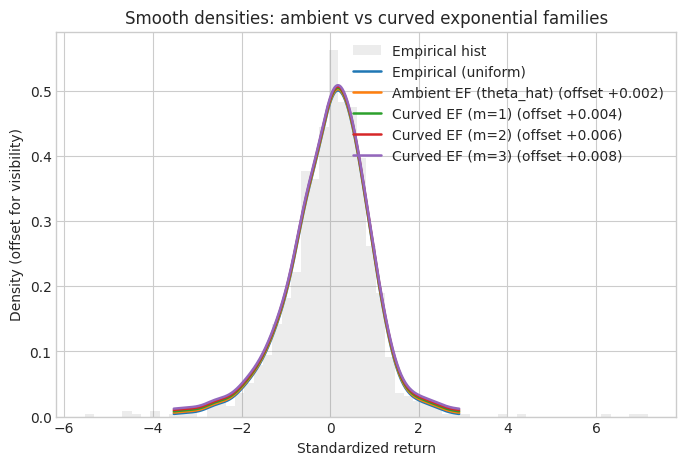

In [4]:

# Overlay the exponential-family fits as smooth densities on standardized returns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Helper: normalized weights for a given theta (EF defined on empirical support)
def model_weights(theta):
    u = Tmat @ theta
    u_max = float(u.max())
    w = np.exp(u - u_max)
    w = w / float(w.sum())
    return w

models = [
    {"label": "Empirical (uniform)", "weights": np.ones_like(x, dtype=float) / len(x)},
    {"label": "Ambient EF (theta_hat)", "weights": model_weights(theta_hat)},
    {"label": f"Curved EF (m={m_star})", "weights": model_weights(theta_star)},
]

# Add top few curved models by score (in case they differ from m_star)
top_curved = sorted(scores, key=lambda s: s["score"], reverse=True)[:3]
seen = {m["label"] for m in models}
for s in top_curved:
    theta_m = theta_hat + s["Vm"] @ s["beta"]
    label = f"Curved EF (m={s['m']})"
    if label in seen:
        continue
    models.append({"label": label, "weights": model_weights(theta_m)})
    seen.add(label)

# Grid for smooth density plots
grid = np.linspace(np.percentile(x, 0.5), np.percentile(x, 99.5), 400)

plt.figure(figsize=(8, 5))
plt.hist(x, bins=60, density=True, alpha=0.15, color='gray', edgecolor='none', label='Empirical hist')

offset_step = 0.002  # small vertical offset to separate overlapping curves visually
for i, m in enumerate(models):
    w = m["weights"]
    kde = gaussian_kde(x, weights=w)
    dens = kde(grid)
    offset = offset_step * i
    label = m["label"] if offset == 0 else f"{m['label']} (offset +{offset:.3f})"
    plt.plot(grid, dens + offset, linewidth=1.8, label=label)

plt.xlabel("Standardized return")
plt.ylabel("Density (offset for visibility)")
plt.title("Smooth densities: ambient vs curved exponential families")
plt.legend()
plt.show()


---
## 0. Fit the baseline AR–GARCH–t model

1. Choose model:
   [
   r_t = \mu + \varphi(r_{t-1}-\mu) + \varepsilon_t,\quad
   \varepsilon_t = \sigma_t z_t,
   ]
   [
   \sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2,\quad
   z_t \sim t_\nu(0,1).
   ]

2. Estimate (\hat\theta = (\hat\mu,\hat\varphi,\hat\omega,\hat\alpha,\hat\beta,\hat\nu)) by MLE using a standard GARCH library.

3. From the fitted model, compute for each (t):

   * Fitted conditional variance (\hat\sigma_t^2) from the recursion,
   * Residuals (\hat\varepsilon_t = r_t - \hat\mu - \hat\varphi(r_{t-1}-\hat\mu)),
   * Standardized residuals (\hat z_t = \hat\varepsilon_t / \hat\sigma_t).

All later diagnostics work with (\hat z_t).

In [5]:
clean_mkt = mkt_excess.dropna()

fit = fit_ar_garch_t(clean_mkt.to_numpy())
param_names = ["mu", "phi", "omega", "alpha", "beta", "nu"]

garch_params = pd.Series(fit["params"], index=param_names, name="params")
garch_cov = pd.DataFrame(fit["cov"], index=param_names, columns=param_names)
garch_res = fit["res"]

cond_vol = pd.Series(garch_res.conditional_volatility, index=clean_mkt.index, name="sigma")
resid = pd.Series(garch_res.resid, index=clean_mkt.index, name="resid")
std_resid = resid / cond_vol

garch_fit = pd.DataFrame(
    {
        "r": clean_mkt,
        "sigma": cond_vol,
        "resid": resid,
        "std_resid": std_resid,
    }
)

print("Estimated parameters:")
print(garch_params)
print("\nFirst few standardized residuals:")
print(garch_fit["std_resid"].dropna().head())


Estimated parameters:
mu        0.007628
phi       0.020984
omega     0.009619
alpha     0.447684
beta      0.093708
nu       38.498777
Name: params, dtype: float64

First few standardized residuals:
Date
1926-08-31    0.173952
1926-09-30   -0.042182
1926-10-31   -0.391749
1926-11-30    0.173282
1926-12-31    0.173302
Name: std_resid, dtype: float64


---
## A. Model check: tails

### A1. QQ-plot

1. Sort standardized residuals:
   (\hat z_{(1)} \le \dots \le \hat z_{(T)}).

2. For each rank (i), define empirical probability
   (p_i = \frac{i - 0.5}{T}).

3. Compute theoretical quantiles of (t_{\hat\nu}):
   (q_i = F_{t_{\hat\nu}}^{-1}(p_i)).

4. Plot points ((q_i, \hat z_{(i)})).

   * If the model is OK in the center and tails, points lie roughly on the 45° line.
   * Systematic bending in the tails ⇒ misspecified tails.

(Practically: call a “QQ plot vs Student-t” function on (\hat z_t).)

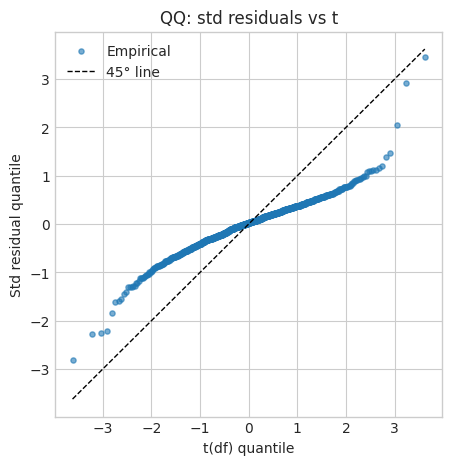

In [6]:
def qq_plot_student_t(std_resid: pd.Series, df: float, ax=None, title: str | None = None):
    z = pd.Series(std_resid).dropna().sort_values().to_numpy()
    n = z.shape[0]
    probs = (np.arange(1, n + 1) - 0.5) / n
    q = stats.t.ppf(probs, df=df)

    ax = ax or plt.gca()
    ax.scatter(q, z, s=14, alpha=0.6, color="tab:blue", label="Empirical")
    lims = [min(q.min(), z.min()), max(q.max(), z.max())]
    ax.plot(lims, lims, color="black", linestyle="--", linewidth=1, label="45° line")
    ax.set_xlabel("t(df) quantile")
    ax.set_ylabel("Std residual quantile")
    if title:
        ax.set_title(title)
    ax.legend()
    return ax


fig, ax = plt.subplots(figsize=(5, 5))
qq_plot_student_t(garch_fit["std_resid"], df=garch_params["nu"], ax=ax, title="QQ: std residuals vs t")
plt.show()


### A2. Tail index (Hill estimator) – optional but useful

Do it for upper tail; similarly for lower if you want.

1. Pick a high threshold (e.g. 5–10% largest values). Let (k) be the number of exceedances, say (k = \lfloor 0.05T \rfloor).

2. Let (Y_{(1)} \le \dots \le Y_{(k)}) be the largest (k) standardized residuals.

3. Hill estimator for tail index (\xi):
   [
   \hat\xi = \frac{1}{k} \sum_{j=1}^k \left( \log Y_{(T-j+1)} - \log Y_{(T-k)} \right).
   ]
   (For negative tail, work with (-\hat z_t).)

4. Compare (\hat\xi) from real data with (\hat\xi) from many *model simulations* (see below). Large discrepancy ⇒ tails not captured.

(In practice: use a “Hill estimator” implementation on the standardized residuals.)

In [7]:
def hill_tail_index(std_resid: pd.Series, *, tail: str = "upper", frac: float = 0.05):
    z = pd.Series(std_resid).dropna()
    if tail == "lower":
        z = -z
    z = np.sort(z.values)
    k = max(1, int(len(z) * frac))
    top = z[-k:]
    threshold = z[-k]
    if threshold <= 0 or np.any(top <= 0):
        return np.nan
    return float(np.mean(np.log(top) - np.log(threshold)))


hill_upper = hill_tail_index(garch_fit["std_resid"], tail="upper", frac=0.05)
hill_lower = hill_tail_index(garch_fit["std_resid"], tail="lower", frac=0.05)

rng = np.random.default_rng(123)
nu = garch_params["nu"]
sim_z = rng.standard_t(df=nu, size=200_000) / np.sqrt(nu / (nu - 2))
hill_sim_upper = hill_tail_index(sim_z, tail="upper", frac=0.05)
hill_sim_lower = hill_tail_index(sim_z, tail="lower", frac=0.05)

print("Hill upper (data):", round(hill_upper, 4))
print("Hill lower (data):", round(hill_lower, 4))
print("Hill upper (t sim):", round(hill_sim_upper, 4))
print("Hill lower (t sim):", round(hill_sim_lower, 4))


Hill upper (data): 0.335
Hill lower (data): 0.334
Hill upper (t sim): 0.2232
Hill lower (t sim): 0.2262


### A3. Tail probabilities

1. Pick a few high thresholds in “sigma units”, e.g.
   (u \in {3,4,5}).

2. Empirical tail probability from data:
   [
   \widehat{p}_{\text{emp}}(u) = \frac{1}{T}\sum_{t=1}^T \mathbf{1}{\hat z_t \le -u}.
   ]

3. Simulate a large i.i.d. sample from (t_{\hat\nu}), or from your full AR–GARCH–t model, get:
   [
   \widehat{p}_{\text{model}}(u) = \frac{1}{N}\sum_{i=1}^N \mathbf{1}{z_i^{\text{sim}} \le -u}.
   ]

4. Compare (\widehat{p}_{\text{emp}}(u)) vs (\widehat{p}_{\text{model}}(u)) for each (u).
   Large underestimation of crash frequency ⇒ model too light-tailed.

If these three checks look “reasonably aligned”, proceed. Otherwise, reconsider the model class.

In [8]:
def tail_probabilities(std_resid: pd.Series, df: float, *, thresholds=(3, 4, 5), n_sim: int = 200_000, rng=None):
    rng = np.random.default_rng(rng)
    z = pd.Series(std_resid).dropna()
    sim = rng.standard_t(df=df, size=n_sim) / np.sqrt(df / (df - 2))
    rows = []
    for u in thresholds:
        emp = float((z <= -u).mean())
        model = float((sim <= -u).mean())
        rows.append({"u": u, "empirical_p": emp, "model_p": model})
    return pd.DataFrame(rows)


tail_probs = tail_probabilities(garch_fit["std_resid"], df=garch_params["nu"], rng=42)
display(tail_probs)


,u,empirical_p,model_p
0,3,0.0,0.001755
1,4,0.0,0.000100
2,5,0.0,0.000000


---
## B. Parameter uncertainty via approximate Bayesian sampling

Goal: do not condition on a single (\hat\theta), but on a *distribution* for (\theta).

### B1. Approximate posterior for (\theta)

A simple, standard approximation:

1. At (\hat\theta), compute the observed Hessian (H(\hat\theta)) of the *negative* log-likelihood:
   [
   H_{ij}(\hat\theta)
   = \left.\frac{\partial^2}{\partial \theta_i \partial \theta_j}
   \big(-\ell(\theta)\big)\right|_{\theta=\hat\theta}.
   ]

2. Approximate covariance matrix:
   [
   \hat\Sigma = H(\hat\theta)^{-1}.
   ]

3. Take a Gaussian approximation to the posterior:
   [
   \theta \mid \text{data} \approx \mathcal{N}(\hat\theta, \hat\Sigma).
   ]

(If your software gives you an estimated covariance matrix of (\hat\theta), just use that as (\hat\Sigma).)

In [9]:
theta_hat = garch_params
theta_cov = garch_cov
eigvals = np.linalg.eigvalsh(theta_cov.to_numpy())

print("Theta hat:")
print(theta_hat)
print("\nCovariance (top-left):")
print(theta_cov.iloc[:3, :3])
print("\nSmallest eigenvalue:", eigvals.min())


Theta hat:
mu        0.007628
phi       0.020984
omega     0.009619
alpha     0.447684
beta      0.093708
nu       38.498777
Name: params, dtype: float64

Covariance (top-left):
                 mu           phi         omega
mu     1.638663e-06 -1.877249e-05 -1.920518e-07
phi   -1.877249e-05  1.078643e-03 -1.389869e-07
omega -1.920518e-07 -1.389869e-07  2.723431e-07

Smallest eigenvalue: 3.7465326516861195e-09


### B2. Parameter draws + simulations in one call
Use the asymptotic Normal approximation of (	heta) and the helper
`run_parameter_uncertainty_experiment` to handle parameter draws, Monte Carlo paths,
and moment calculations in a single step.


In [10]:
n_param_draws = 400
paths_per_draw = 15
horizon = len(clean_mkt)

sim_results = run_parameter_uncertainty_experiment(
    returns=clean_mkt.to_numpy(),
    n_param_draws=n_param_draws,
    n_paths_per_draw=paths_per_draw,
    horizon=horizon,
    seed=99,
)

theta_draws = pd.DataFrame(sim_results["theta_draws"], columns=param_names)

draw_idx = np.repeat(np.arange(n_param_draws), paths_per_draw)
path_idx = np.tile(np.arange(paths_per_draw), n_param_draws)

sim_kurtosis = pd.DataFrame(
    {
        "draw_idx": draw_idx,
        "path": path_idx,
        "sharpe": sim_results["sharpe"],
        "skew": sim_results["skew"],
        "kurt": sim_results["kurtosis"],
    }
)

theta_draws.head(), sim_kurtosis.head()


(         mu       phi     omega     alpha      beta         nu
 0  0.007733  0.006127  0.009669  0.506387  0.059732  38.590449
 1  0.007041  0.010171  0.009219  0.779646  0.081624  39.223262
 2  0.008771  0.015616  0.009627  0.598464  0.058814  38.412030
 3  0.008116  0.002085  0.009954  0.222588  0.106347  38.780010
 4  0.008220 -0.030398  0.009246  0.855369  0.062739  38.640272,
    draw_idx  path    sharpe      skew       kurt
 0         0     0  0.082789 -0.119169   3.404308
 1         0     1  0.048741  0.425462   3.717567
 2         0     2  0.073208  0.107981   1.251803
 3         0     3  0.098747  1.714940  14.096991
 4         0     4  0.086147  0.021150   4.817915)

### B3. Simulate paths and collect skew/kurtosis
Choose horizon and paths per draw; reuse the fitted variance and last return as
initial conditions. The helper returns Sharpe/skew/kurtosis stacked across draws.


In [11]:
summary = sim_kurtosis[["sharpe", "skew", "kurt"]].describe().loc[["mean", "std", "50%", "75%"]]
display(summary)


,sharpe,skew,kurt
mean,0.051652,0.008076,11.898638
std,0.033510,1.510966,35.580844
50%,0.051747,0.001014,1.813895
75%,0.073990,0.134508,7.383187


---
## C. Nonparametric block bootstrap

Goal: see how much of your kurtosis behaviour can be explained *without any parametric model*.

### C1. Choose block length

1. Let (\ell) be block length in months. For monthly data, a typical start is (\ell = 6) or (\ell = 12).
   Trade-off:

   * Larger (\ell): preserve more dependence structure.
   * Smaller (\ell): more independent blocks, less variance.

### C2. Construct bootstrap samples

Let (T) be your sample size.

For (k = 1,\dots,K) (e.g. (K=2000)):

1. Draw blocks with replacement:

   * For each step, pick a random starting index (s) in ({1,\dots,T-\ell+1}).
   * Take the block ((r_s, r_{s+1},\dots,r_{s+\ell-1})).
   * Concatenate blocks until you reach length at least (T); cut off the extra excess to get exactly (T) points.

   This gives a bootstrap series ({r_t^{*(k)}}_{t=1}^T).

2. Compute kurtosis (\widehat{\gamma}_2^{*(k)}) (and skewness) on that series.

The empirical distribution of ({\widehat{\gamma}_2^{*(k)}}) is a **model-free** approximation to the sampling distribution of kurtosis given your data.

In [12]:
def block_bootstrap_stats(series: pd.Series, *, block_size: int = 12, n_boot: int = 20000, rng=None):
    """Simple moving-block bootstrap; keeps memory small by streaming draws."""
    rng = np.random.default_rng(rng)
    arr = series.dropna().to_numpy()
    n = arr.shape[0]
    if n == 0 or n_boot <= 0:
        return pd.DataFrame(columns=["skew", "kurt"])

    use_blocks = block_size is not None and block_size > 1 and n >= block_size
    skews = np.empty(n_boot)
    kurts = np.empty(n_boot)

    if use_blocks:
        starts = np.arange(0, n - block_size + 1)
        draws_needed = int(np.ceil(n / block_size))
        for i in range(n_boot):
            chosen = rng.integers(0, starts.shape[0], size=draws_needed)
            pieces = [arr[s : s + block_size] for s in starts[chosen]]
            sample = np.concatenate(pieces)[:n]
            skews[i] = stats.skew(sample, bias=False, nan_policy="omit")
            kurts[i] = stats.kurtosis(sample, bias=False, fisher=False, nan_policy="omit")
    else:
        for i in range(n_boot):
            idx = rng.integers(0, n, size=n)
            sample = arr[idx]
            skews[i] = stats.skew(sample, bias=False, nan_policy="omit")
            kurts[i] = stats.kurtosis(sample, bias=False, fisher=False, nan_policy="omit")

    return pd.DataFrame({"skew": skews, "kurt": kurts})


boot_stats = block_bootstrap_stats(mkt_excess, block_size=12, n_boot=20000, rng=321)
boot_stats.head()


,skew,kurt
0,-0.036387,7.996270
1,-0.218892,8.255534
2,0.527185,11.799735
3,0.380086,9.449403
4,0.453447,11.322782


---
## D. Compare all three views

1. **Empirical kurtosis** from original data: (\widehat{\gamma}_2^{\text{obs}}).

2. **Nonparametric block bootstrap**: distribution of ({\widehat{\gamma}_2^{*(k)}}).

   * Gives a model-free view.

3. **Parametric, uncertainty-aware AR–GARCH–t**:

   * Distribution of ({\widehat{\gamma}_2^{(m,b)}}) from Section B.

Then look at:

* Does (\widehat{\gamma}_2^{\text{obs}}) sit in a reasonable region of both distributions?
* How different are the two distributions (nonparam vs parametric)?
* If they are similar, the AR–GARCH–t is compatible with the nonparametric evidence.
* If they differ strongly, the model is likely misspecified in tails or dependence.

Empirical kurtosis: 10.398


,mean,std,25%,50%,75%
source,,,,,
block_boot,9.745206,2.223256,8.298476,9.961317,11.366599
parametric,11.898638,35.580844,0.505533,1.813895,7.383187


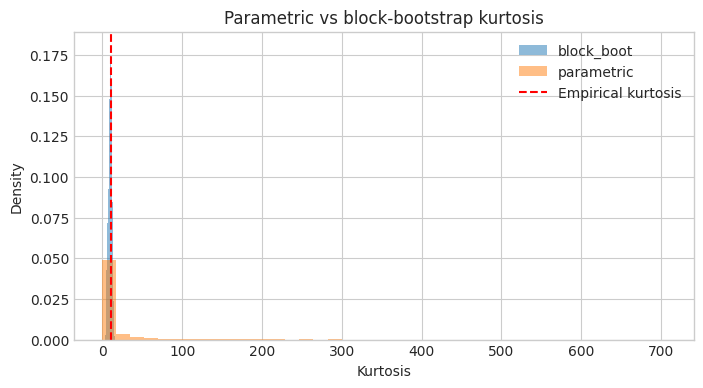

In [13]:
empirical_kurt = metrics.sample_kurtosis(mkt_excess)

comparison = pd.concat(
    [
        boot_stats.assign(source="block_boot"),
        sim_kurtosis.assign(source="parametric"),
    ],
    ignore_index=True,
)

summary = comparison.groupby("source")["kurt"].describe()[["mean", "std", "25%", "50%", "75%"]]
print("Empirical kurtosis:", round(empirical_kurt, 3))
display(summary)

fig, ax = plt.subplots(figsize=(8, 4))
for label, df in comparison.groupby("source"):
    data = df["kurt"].dropna()
    if data.empty:
        continue
    ax.hist(data, bins=40, alpha=0.5, density=True, label=label)
ax.axvline(empirical_kurt, color="red", linestyle="--", linewidth=1.5, label="Empirical kurtosis")
ax.set_xlabel("Kurtosis")
ax.set_ylabel("Density")
ax.set_title("Parametric vs block-bootstrap kurtosis")
ax.legend()
plt.show()
